# Task 3: Try Unet

https://stanford.edu/~shervine/blog/pytorch-how-to-generate-data-parallel



Start simple with provided segmentation models from pytorch
https://github.com/qubvel/segmentation_models.pytorch

also https://amaarora.github.io/2020/09/13/unet.html
and https://github.com/amaarora/amaarora.github.io/blob/master/nbs/Training.ipynb

https://www.pyimagesearch.com/2021/11/08/u-net-training-image-segmentation-models-in-pytorch/

In [1]:
from task3.utils.config import *
from task3.utils.data_utils import evaluate, save_zipped_pickle, load_zipped_pickle
from task3.utils.img_utils import show_img_batch
from task3.utils.utils import upscale, get_img_dims
import pickle
import gzip
import importlib
import sys
import time
import json
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from datetime import datetime
import segmentation_models_pytorch as smp
from torchmetrics import IoU
import torchvision
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from loguru import logger
from torch.utils.tensorboard import SummaryWriter

## Params

In [2]:
config = init(config='configs/raphaela.yaml')

In [3]:
device = config['device']
sys_device = 'cuda' if torch.cuda.is_available() else 'cpu'

logger.info(f'You are using {device}.')

if device != sys_device:
    logger.warning(f'You are using {device} but system device was found to be {sys_device}. Check your device choice in config.py.')

2022-01-01T13:32:58.941727+0000 INFO You are using cpu.


## Define Model

In [5]:
model = get_model(config)

2021-12-31T14:45:01.990951+0000 INFO model params set to: {'encoder_name': 'resnet34', 'encoder_weights': None, 'in_channels': 1, 'classes': 1, 'encoder_depth': 5, 'decoder_use_batchnorm': True, 'decoder_channels': [256, 128, 64, 32, 16], 'decoder_attention_type': None, 'activation': 'sigmoid', 'aux_params': None}


## Load data

In [6]:
training_loader, validation_loader, test_loader = get_data_loader(config, mode='train', get_subset=False)

dict_keys(['name', 'video', 'box', 'label', 'frames', 'dataset', 'roi'])
2021-12-30T16:34:18.718987+0000 DEBUG Loaded samples: ['11NZLRCO13', 'QZA3WA0E2X', 'R82Q2AL9P7', '1XHV0Q88M5', 'E9AHVWGBUF', 'WO0OOZLXP6', 'ZMJIDN442P', 'OYZFKJR8U3', '3DGDHONGJW', 'YEZ7BPLZW0', 'W00G0Q112W', 'JANFS05F33', 'ONA22CCCFQ', 'EH667Z5JMT', '55M79ZANVX', 'H7G0BX4HFV', '571G03ZYDA', 'MHD497XXNA', 'TFDB2R0ZSA']
2021-12-30T16:34:26.859482+0000 DEBUG Exclude samples: None, include samples: None, applied transforms: Compose(
    ToTensor()
)
2021-12-30T16:34:26.860837+0000 DEBUG Dataset creation: train
2021-12-30T16:34:26.861952+0000 DEBUG Dataset creation: validation
2021-12-30T16:34:26.862799+0000 DEBUG Dataset creation: test
dict_keys(['name', 'video', 'roi'])
2021-12-30T16:34:33.611839+0000 DEBUG Loaded samples: ['RZ9W7OK2EO', '401JD35E1A', 'O7WUJ71C15', '7UXIXUBK2G', 'JQX264DTZ0', 'NHC30J31YN', 'CD4RIAOCHG', 'QJTAVYCG6M', '3WOQKZBVRN', 'UB7LFQKZT5', 'SZKYOVQ4ZP', 'ESY800XYMN', '1QSFD8ORNM', '0MVRNDWR1G',

## Optimizer & Loss

Some optimization algorithms such as Conjugate Gradient and LBFGS need to reevaluate the function multiple times, so you have to pass in a closure that allows them to recompute your model.

https://pytorch.org/docs/stable/optim.html

In [7]:
optimizer = get_optimizer(model, config)
criterion = get_loss(model, config)

# learning rate scheduler TODO add to config
# decays lr after 10 epochs by factor 0.1, e.g. from 0.005 to 0.0005 every 10 epochs

lr_scheduler = get_lrscheduler(optimizer, config)
#lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)

#torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10,
#                                           threshold=0.0001, threshold_mode='rel', cooldown=0,
#                                           min_lr=0, eps=1e-08, verbose=False)
num_epochs = config['training'].get('epochs', 1)
save_path = config['training'].get('save_path', 'outputs')

2021-12-30T16:34:41.083696+0000 INFO Using BCELoss() as loss function.


In [8]:
# initialize metric
metric = IoU(num_classes=2) # num classes in Unet=1 for binary segmentation, corresponds to 2 in IoU score

## Set-up Tensorboard + log dirs

In [9]:
writer = SummaryWriter(save_path)

In [10]:
## FIX DOENSN'T WORK

f = open(save_path+'/config.txt', 'w+')
f.write(config['run_notes'])
f.write(json.dumps(config))


1294

## Training loop

In [11]:
len(training_loader)

46

In [ ]:
def train_one_epoch(epoch_index, tb_writer):
    running_loss = 0.
    running_score = 0.
    last_loss = 0.

    for i, batch in enumerate(training_loader):
        inputs, labels = batch['frame_cropped'], batch['label_cropped']

        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        outputs = model(inputs)
        labels_fl = labels.float()
        
        # Compute the loss and its gradients
        loss = criterion(outputs, labels_fl) # if BCE we need floats (0.0 or 1.0) for labels
        # we need a threshold when calcualting IoU as we have a sigmoid output -> [0,1] but we need (0,1)
        outputs_thr = outputs > 0.5
        score = metric(outputs_thr, labels) # here we need bool for labels not float

        loss.backward()

        # Adjust learning weights
        optimizer.step()

        # Gather data and report
        running_loss += loss.item()
        running_score += score.item()
        
        # report average per-batch loss of last for last ... batches
        if i % 5 == 4:
            last_loss = running_loss / 5 # loss per batch
            last_score = running_score / 5 # IoU per batch
            print('  batch {} loss: {}'.format(i + 1, last_loss))
            print('  batch {} IoU: {}'.format(i + 1, last_score))
            tb_x = epoch_index * len(training_loader) + i + 1
            tb_writer.add_scalar('Loss/train', last_loss, tb_x)
            tb_writer.add_scalar('IoU/train', last_score, tb_x)
            running_loss = 0.
            running_score = 0.

    return last_loss, last_score

In [ ]:
# Initializing in a separate cell so we can easily add more epochs to the same run
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
writer = SummaryWriter(save_path+'/mitrial_valve_{}'.format(timestamp))


print(f'training for {num_epochs} epochs')
print(f'batch size: ', config['data'].get('batch_size', None))
print(f'saving results and models to {save_path}')
print('training model...')

start = time.time()
epoch_number = 0
best_vloss = 1_000_000.
best_vscore = 1_000_000.

for epoch in range(num_epochs):
    print('\nEPOCH {}:'.format(epoch_number + 1))
    start_epoch = time.time()
    # Make sure gradient tracking is on, and do a pass over the data
    model.train(True)
    avg_loss, avg_score = train_one_epoch(epoch_number, writer)
    
    # We don't need gradients on to do reporting
    model.train(False)

    running_vloss = 0.0
    running_vscore = 0.0

    # validate model for every epoch
    for i, vbatch in enumerate(validation_loader):
        vinputs, vlabels = vbatch['frame_cropped'], vbatch['label_cropped']
        voutputs = model(vinputs)
        vlabels_fl = vlabels.float()
        vloss = criterion(voutputs, vlabels_fl)
        voutputs_thr = voutputs > 0.5
        vscore = metric(voutputs_thr, vlabels)
        
        running_vloss += vloss
        running_vscore += vscore

    avg_vloss = running_vloss / (i + 1)
    avg_vscore = running_vscore / (i + 1)
    print('LOSS train {} valid {}'.format(avg_loss, avg_vloss))
    print('IOU train {} valid {}'.format(avg_score, avg_vscore))

    # Log the running loss averaged per batch
    # for both training and validation
    writer.add_scalars('Training vs. Validation Loss',
                    { 'Training' : avg_loss, 'Validation' : avg_vloss },
                    epoch_number + 1)
    writer.add_scalars('Training vs. Validation IoU',
                    { 'Training' : avg_score, 'Validation' : avg_vscore },
                    epoch_number + 1)

    # write last figure of batch to tensorboard
    fimg_grid = torchvision.utils.make_grid(vinputs)
    limg_grid = torchvision.utils.make_grid(vlabels)
    pimg_grid = torchvision.utils.make_grid(voutputs_thr.detach())
    
    writer.add_image(f'{save_path}_epoch_{epoch_number}_frame_valiou_{vscore}', fimg_grid)
    writer.add_image(f'{save_path}_epoch_{epoch_number}_label_valiou_{vscore}', limg_grid)
    writer.add_image(f'{save_path}_epoch_{epoch_number}_pred_valiou_{vscore}', pimg_grid)

    writer.flush()

    # Track best performance, and save the model's state, could also use IoU instead of loss 
    # Or use Jaccard loss as it is a direct proxy to IoU
    if avg_vloss < best_vloss:
        best_vloss = avg_vloss
        model_path = save_path + '/model_{}_{}'.format(timestamp, epoch_number)
        torch.save(model.state_dict(), model_path)
    
    epoch_duration = (time.time()-start_epoch)/60
    print(f'Epoch {epoch_number} finished in {epoch_duration} min')

    epoch_number += 1

duration = (time.time()-start)/60
print(f'\nTraining finished in {duration} min')

## Restore saved model and run inference for submission

In [4]:
load_dir = 'runs/mv_training_7/model_20211230_133722_20'
submission_loader = get_data_loader(config, mode='submission', get_subset=False)
#model = smp.Unet(**config['model'].get('smp-unet'))
model = get_model(config) 
model.to(device) # if not called wrong input shape (unclear why)
model.load_state_dict(torch.load(load_dir))
model.eval()

dict_keys(['name', 'video', 'roi'])
2022-01-01T13:33:15.817031+0000 DEBUG Loaded samples: ['RZ9W7OK2EO', '401JD35E1A', 'O7WUJ71C15', '7UXIXUBK2G', 'JQX264DTZ0', 'NHC30J31YN', 'CD4RIAOCHG', 'QJTAVYCG6M', '3WOQKZBVRN', 'UB7LFQKZT5', 'SZKYOVQ4ZP', 'ESY800XYMN', '1QSFD8ORNM', '0MVRNDWR1G', 'VODEK84RH4', '1EKDG3M9L1', 'QQW12K1U3U', 'D271IBSMUW', 'TYM0IJW004', '8FKMSXTPSJ']
2022-01-01T13:33:35.538495+0000 DEBUG Exclude samples: None, include samples: None, applied transforms: Compose(
    ToTensor()
)
2022-01-01T13:33:36.022980+0000 INFO model params set to: {'encoder_name': 'resnet34', 'encoder_weights': None, 'in_channels': 1, 'classes': 1, 'encoder_depth': 5, 'decoder_use_batchnorm': True, 'decoder_channels': [256, 128, 64, 32, 16], 'decoder_attention_type': 'scse', 'activation': 'sigmoid', 'aux_params': None}


UnetPlusPlus(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=Tru

In [5]:
len(submission_loader)

1572

### predict and scale predictions

In [6]:
lookup_test = pd.read_csv('data/lookup_test.csv')

predictions = []

for i, batch in enumerate(submission_loader):
    frame = batch['frame_cropped']
    name = batch['name']
    prediction = model(frame)
    prediction_thr = prediction > 0.5
    
    img_dims = get_img_dims(lookup_test, name[0])
    roi_coord = (sample_meta.roi_coord).values[0]
    roi_dims = (sample_meta.roi_dims).values[0]
    
    pred_squeezed = prediction_thr.squeeze(0).squeeze(0)
    pred_scaled = upscale(pred_squeezed.numpy().astype(np.uint8), img_dims, roi_coord, roi_dims)
    
    # name needs to be string
    # prediction needs to be 2D numpy bool array
    predictions.append({
       'name': name[0],
        'prediction': pred_scaled.squeeze(0).numpy().astype(bool)
        }
    )
    #print(name)
    #print('orig_frame_dim', batch['orig_frame_dims'])
    #print('frame shape', frame.shape)
    #print('pred shape', prediction_thr.shape)
    #print('img_dims', img_dims)
    #print('pred scaled shape', pred_scaled.shape)
    #show_img_batch(batch, pred=prediction_thr.detach())
    #print('\n----------------------------------------\n')

In [7]:
predictions

[{'name': 'RZ9W7OK2EO',
  'prediction': array([[False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         ...,
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False]])},
 {'name': 'RZ9W7OK2EO',
  'prediction': array([[False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         ...,
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False]])},
 {'name': 'RZ9W7OK2EO',
  'prediction': array([[False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., Fals

In [12]:
#save_zipped_pickle(predictions, 'submissions/mv_run7_unet++_resnet34_attention_reshaped.pkl')

---

## Aggregate frames back into 20 videos

In [8]:
df = pd.DataFrame.from_dict(predictions)

def mySum(dataframe):
    return np.stack(dataframe, axis=2) # make sure dims are correct (image_x, image_y, num_frames)

res = df.groupby('name').agg(mySum).reset_index(drop=False)
submissions_corrected = pd.DataFrame.to_dict(res, orient='records')
submissions_corrected

[{'name': '0MVRNDWR1G',
  'prediction': array([[[False, False, False, ..., False, False, False],
          [False, False, False, ..., False, False, False],
          [False, False, False, ..., False, False, False],
          ...,
          [False, False, False, ..., False, False, False],
          [False, False, False, ..., False, False, False],
          [False, False, False, ..., False, False, False]],
  
         [[False, False, False, ..., False, False, False],
          [False, False, False, ..., False, False, False],
          [False, False, False, ..., False, False, False],
          ...,
          [False, False, False, ..., False, False, False],
          [False, False, False, ..., False, False, False],
          [False, False, False, ..., False, False, False]],
  
         [[False, False, False, ..., False, False, False],
          [False, False, False, ..., False, False, False],
          [False, False, False, ..., False, False, False],
          ...,
          [False, False,

In [6]:
# save in correct format, all frames aggregated into 20 videos
save_zipped_pickle(submissions_corrected, 'submissions/mv_run7_unet++_resnet34_attention_restarted.pkl')

### Debugging submission aggregation

In [4]:
submission = load_zipped_pickle('submissions/mv_run7_unet++_resnet34_attention_reshaped.pkl')

/tmp/ipykernel_2277299/425511299.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=(8,6))


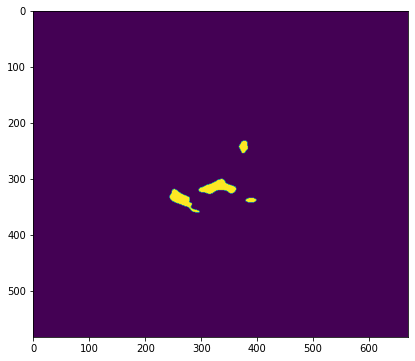

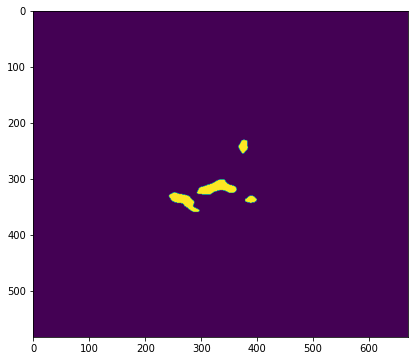

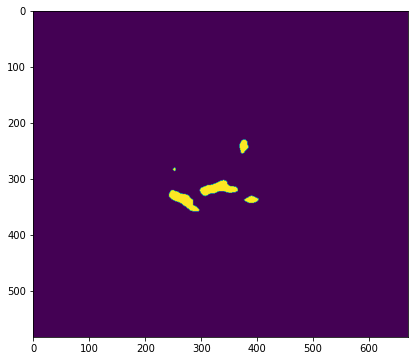

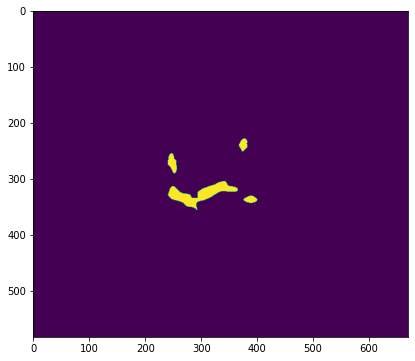

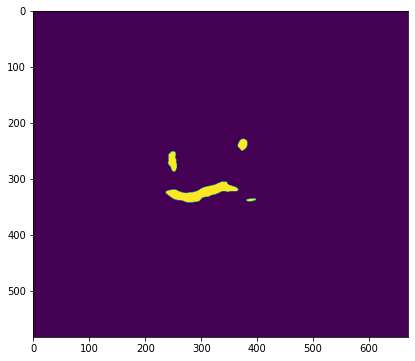

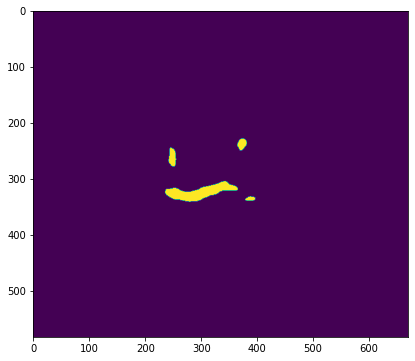

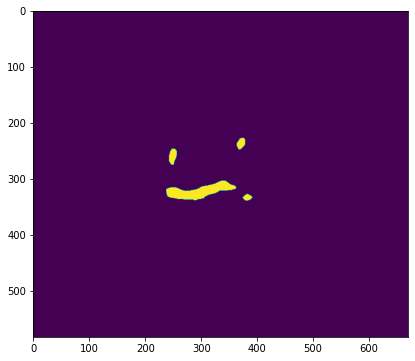

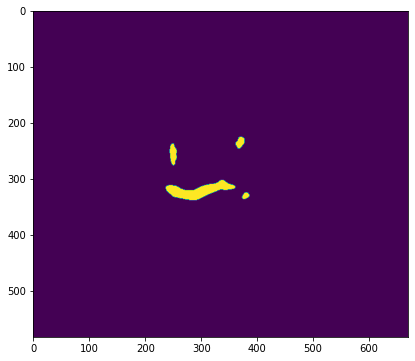

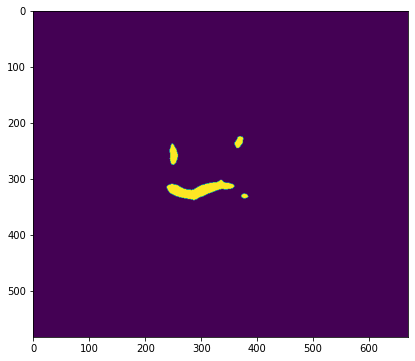

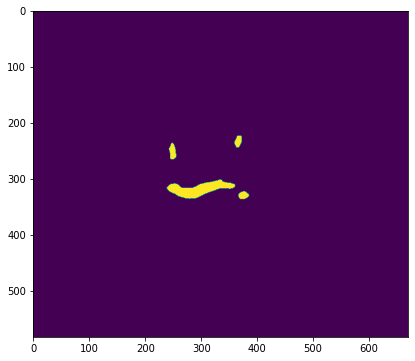

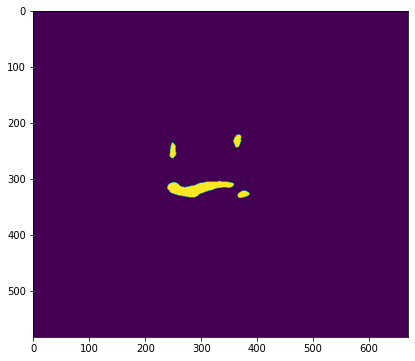

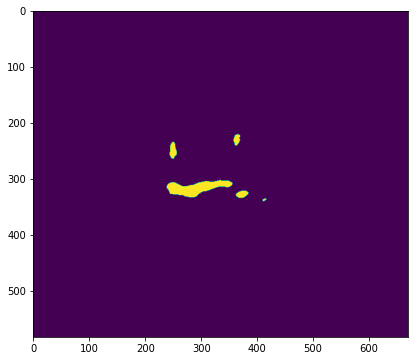

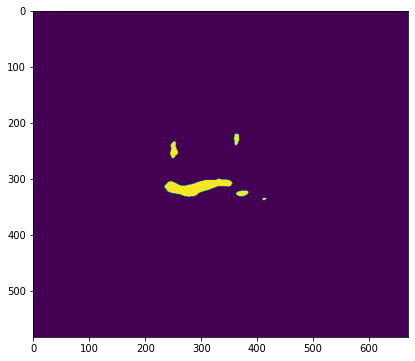

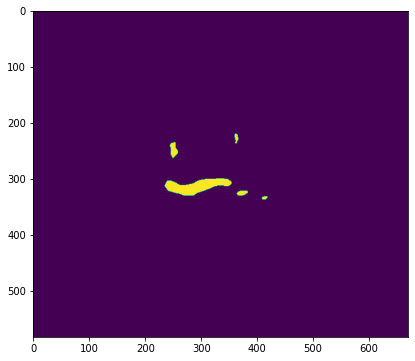

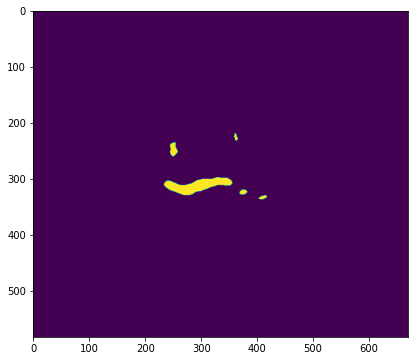

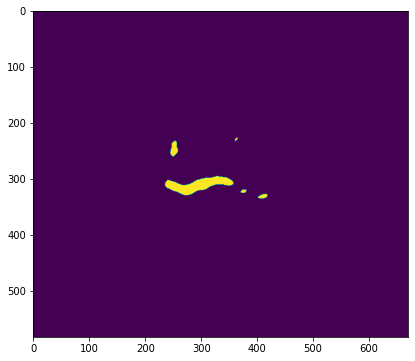

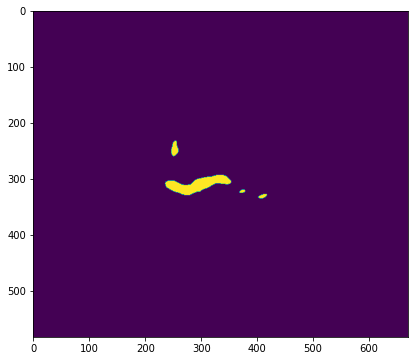

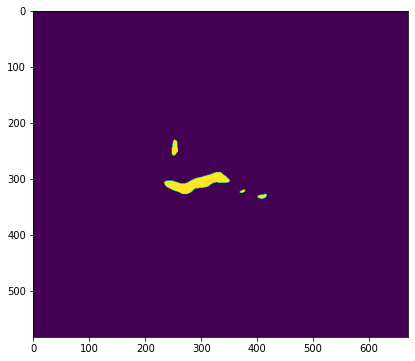

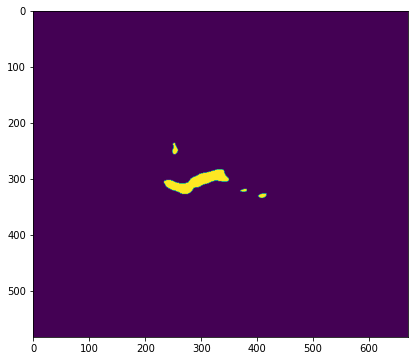

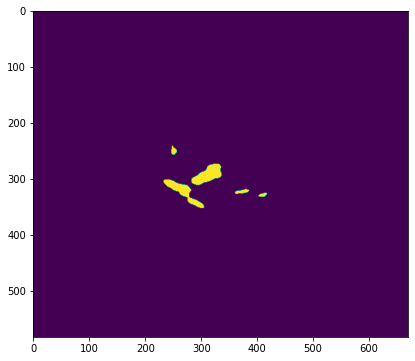

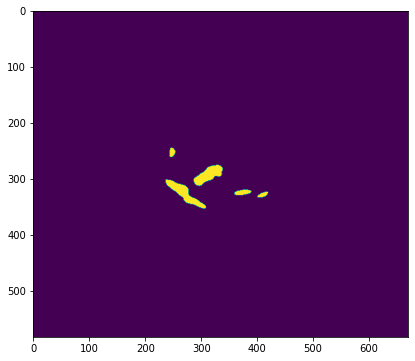

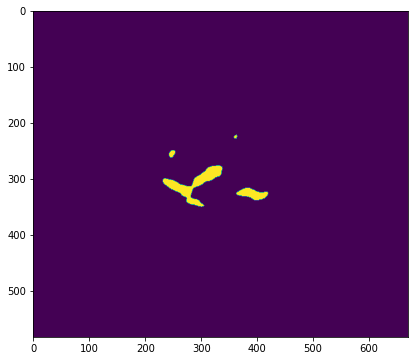

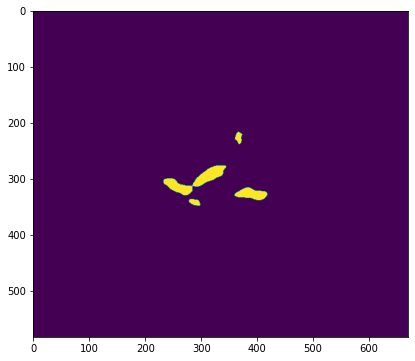

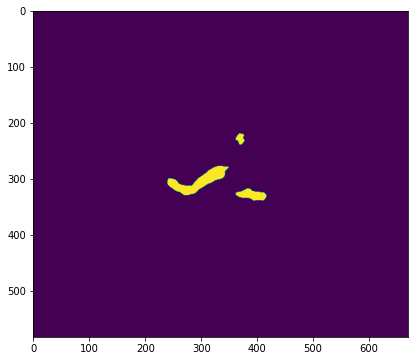

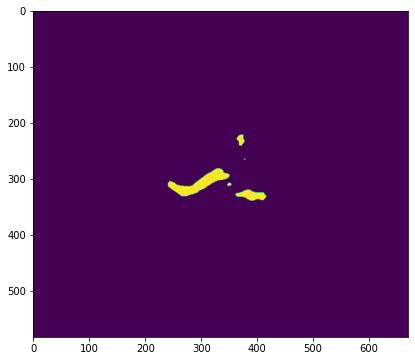

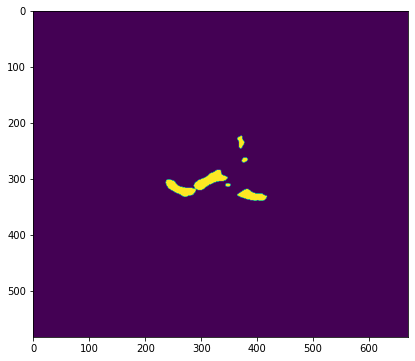

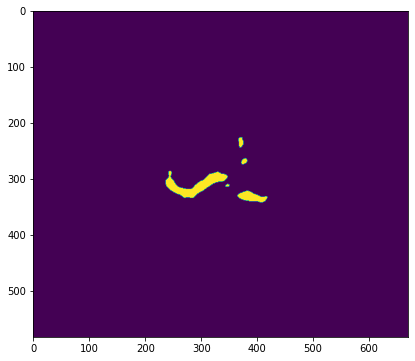

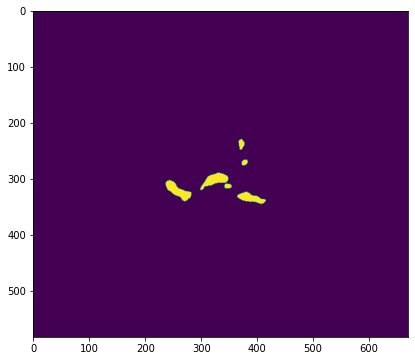

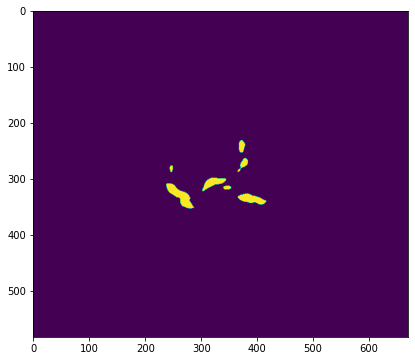

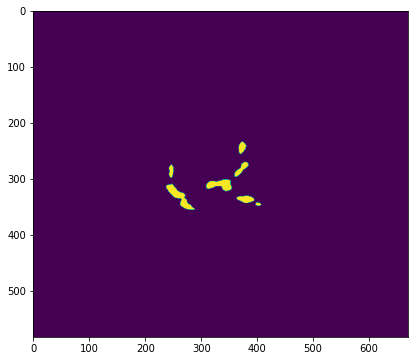

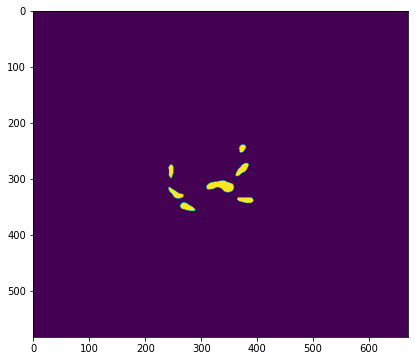

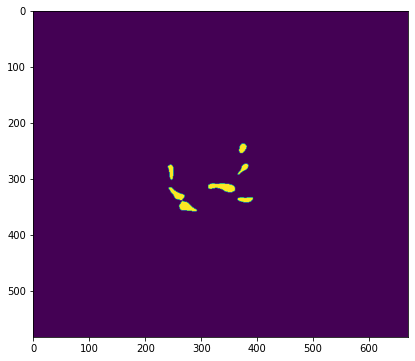

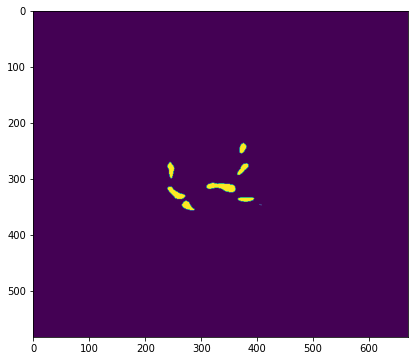

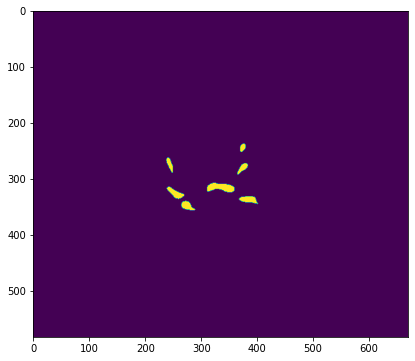

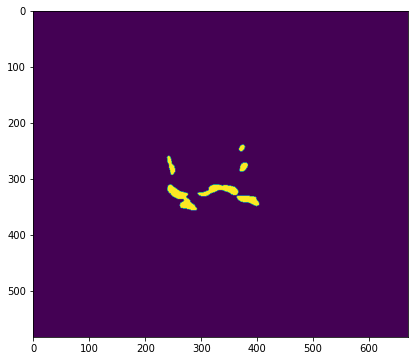

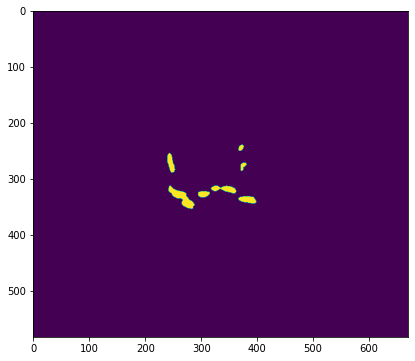

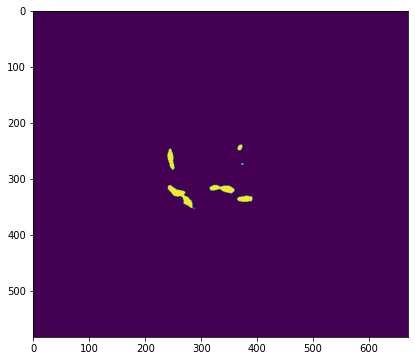

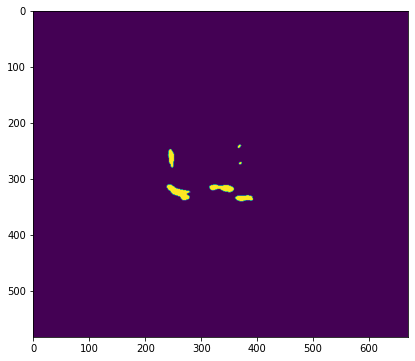

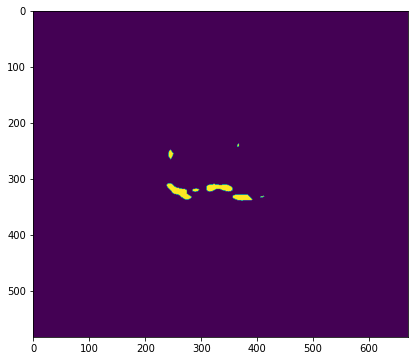

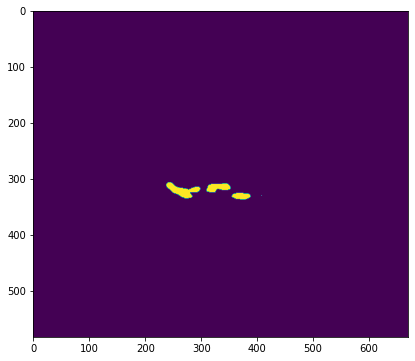

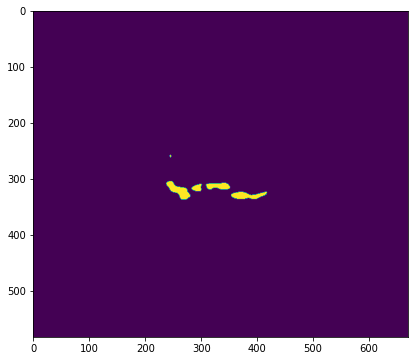

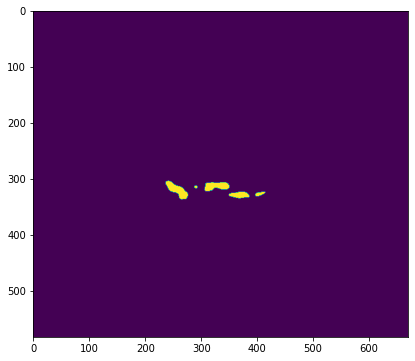

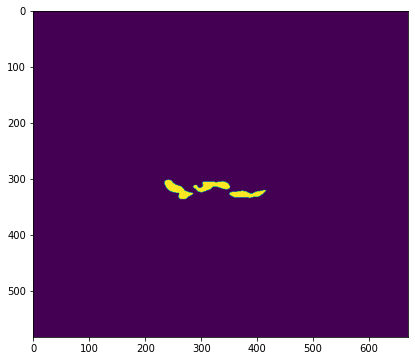

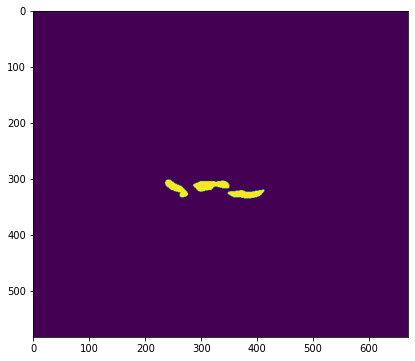

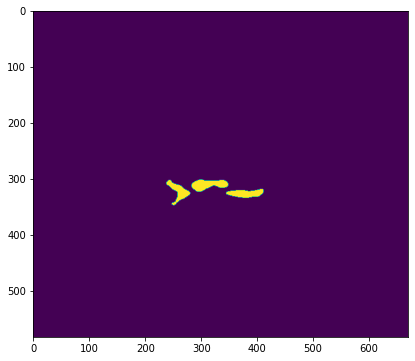

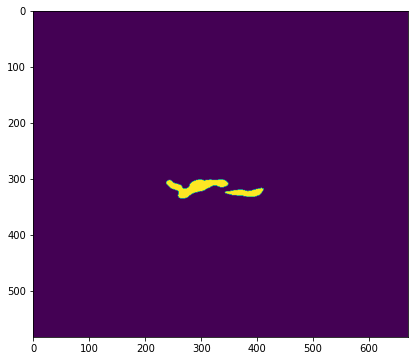

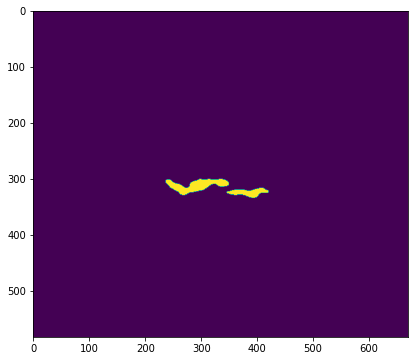

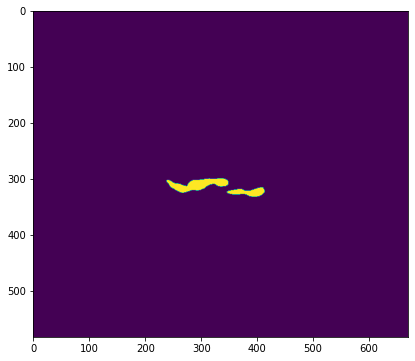

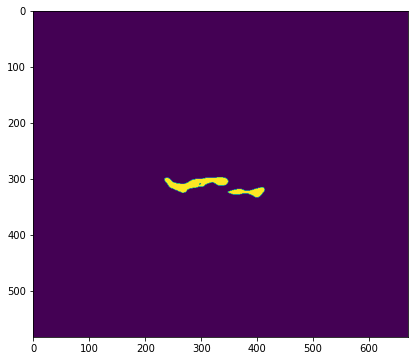

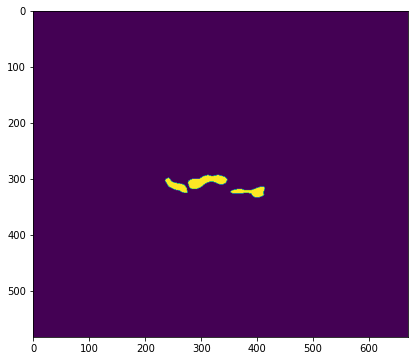

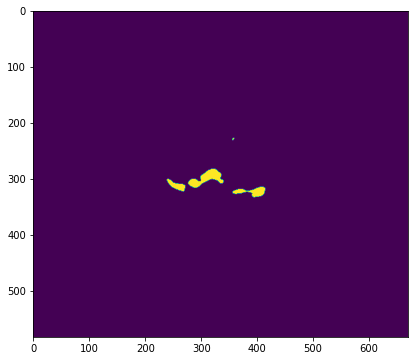

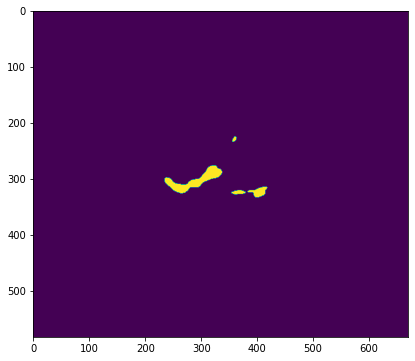

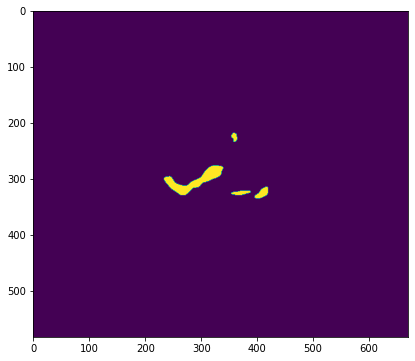

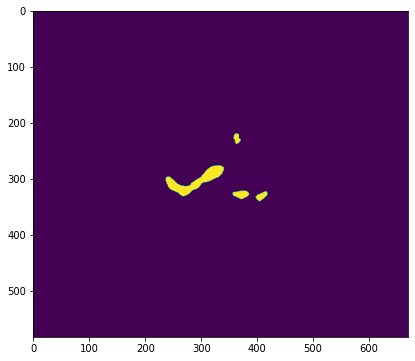

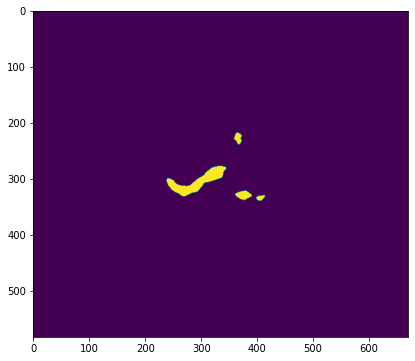

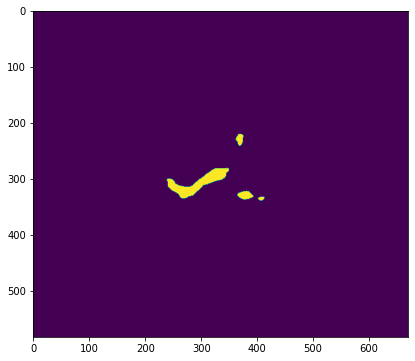

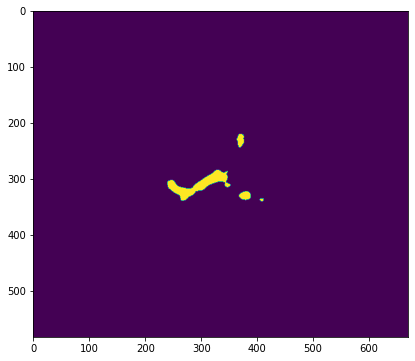

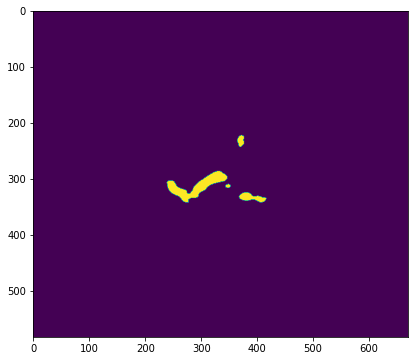

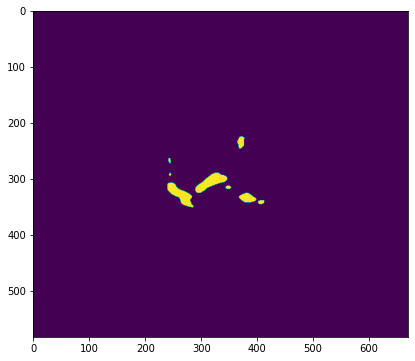

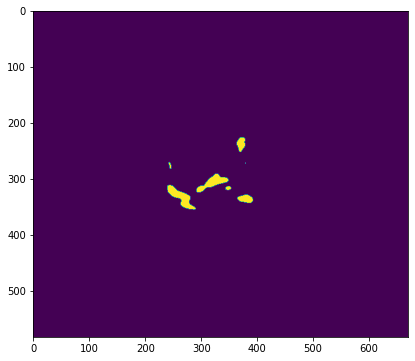

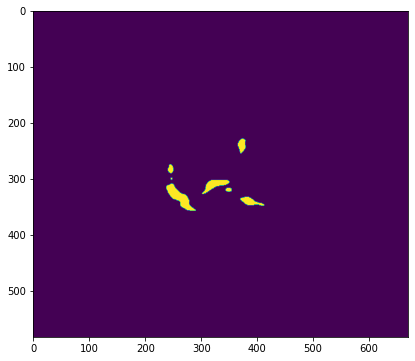

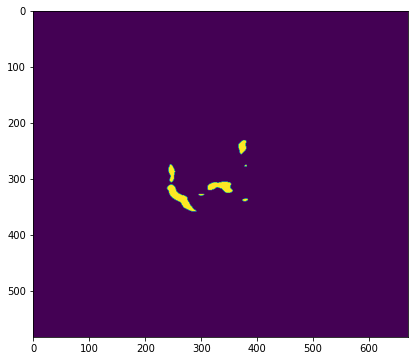

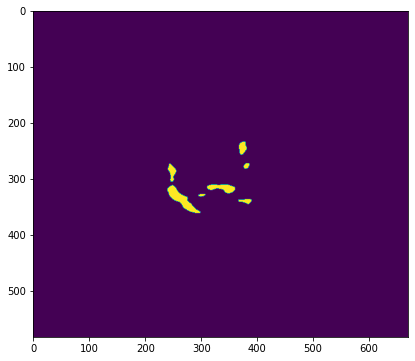

In [24]:
for idx, item in enumerate(submission):
    name = item['name']
    pred = item['prediction']

    if name == '0MVRNDWR1G':
        #print(name, pred.shape)
        fig, ax = plt.subplots(figsize=(8,6))
        ax.imshow(pred)

/tmp/ipykernel_2277299/1103831603.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=(8,6))


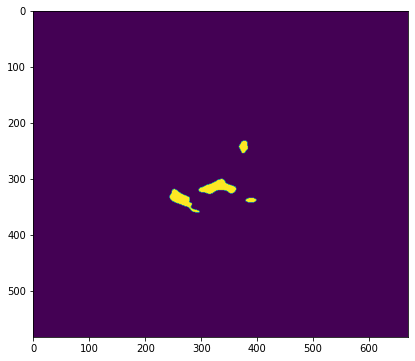

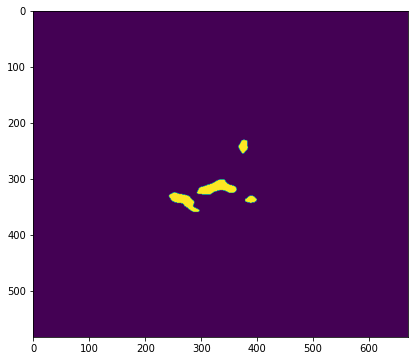

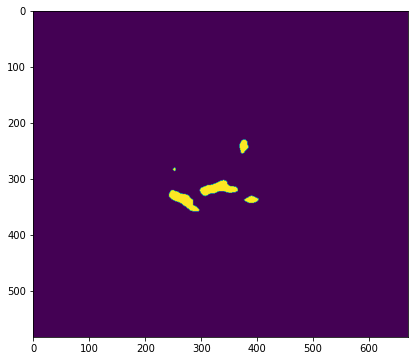

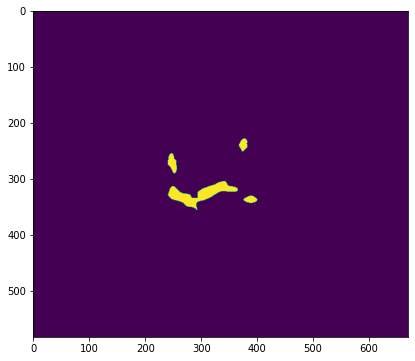

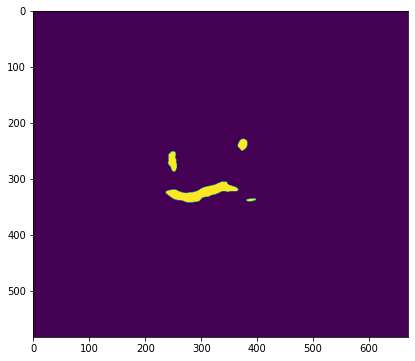

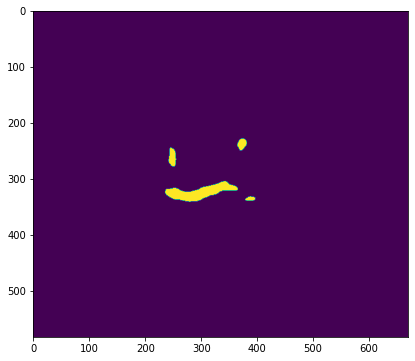

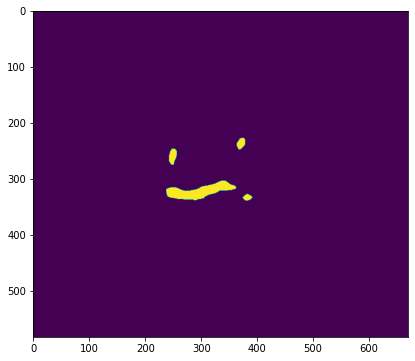

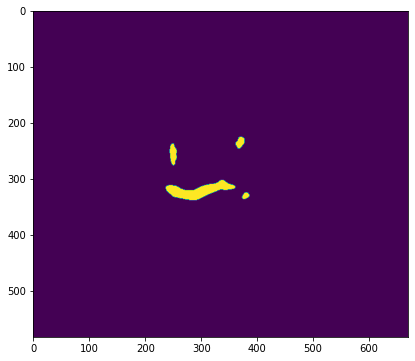

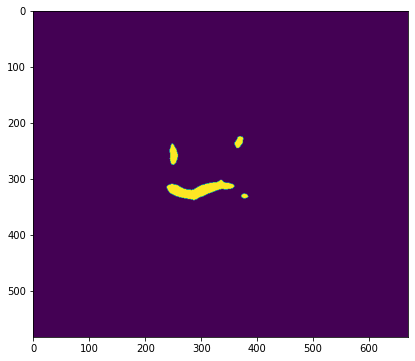

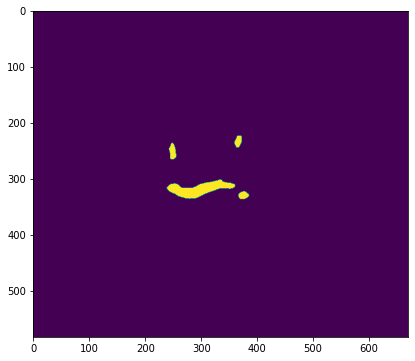

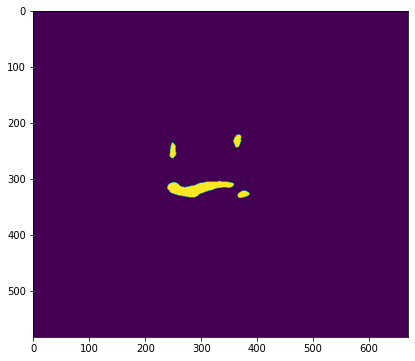

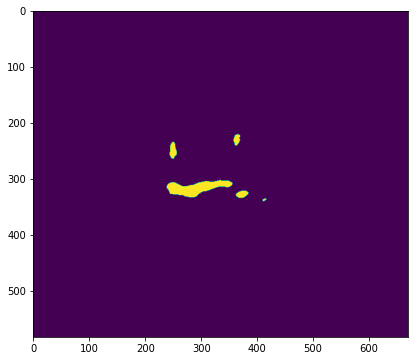

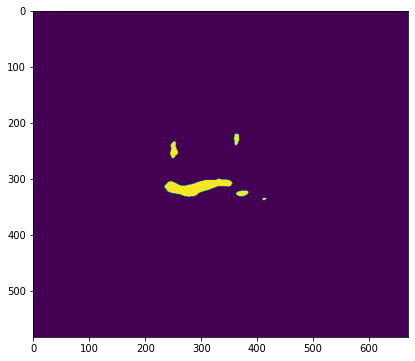

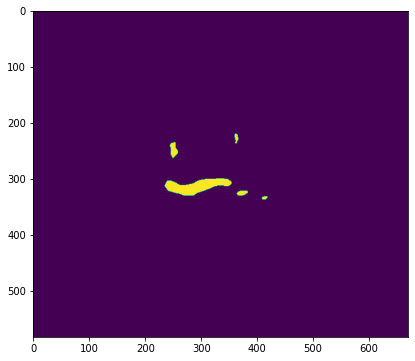

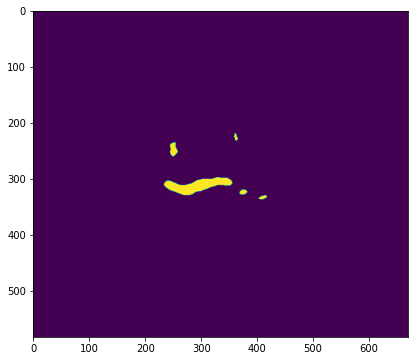

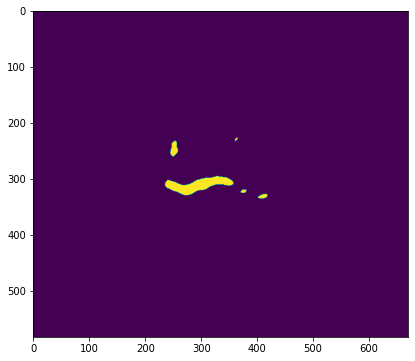

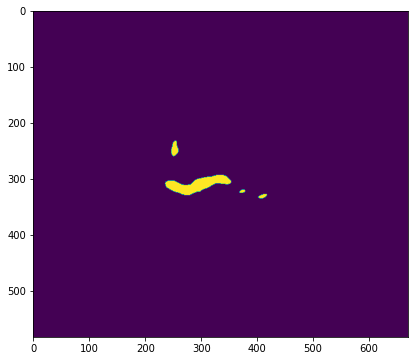

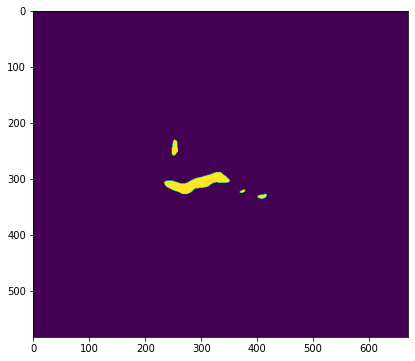

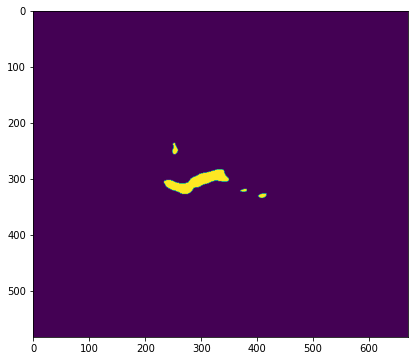

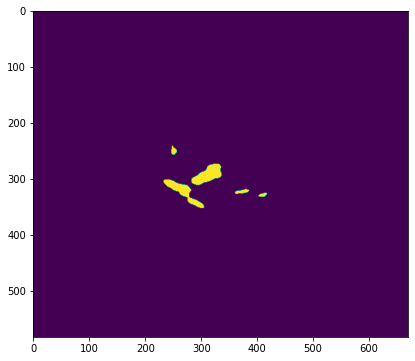

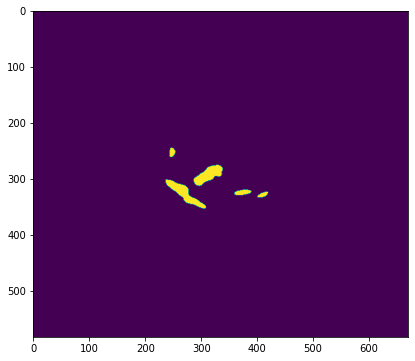

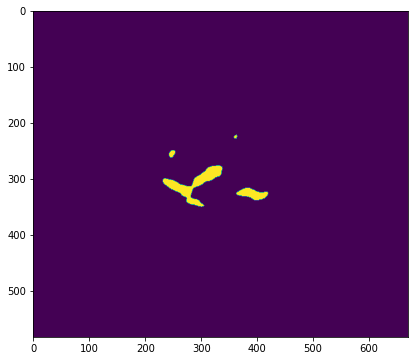

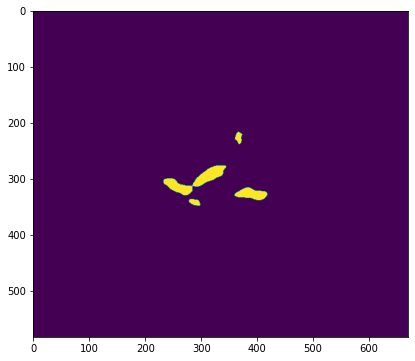

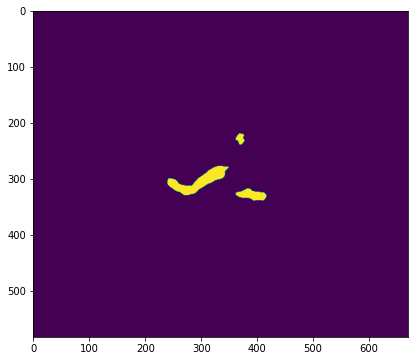

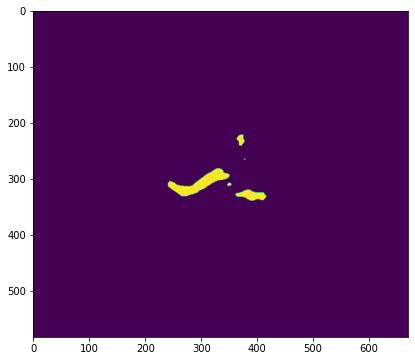

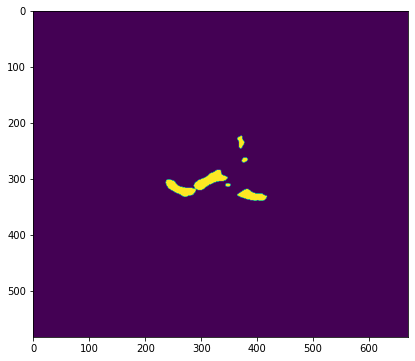

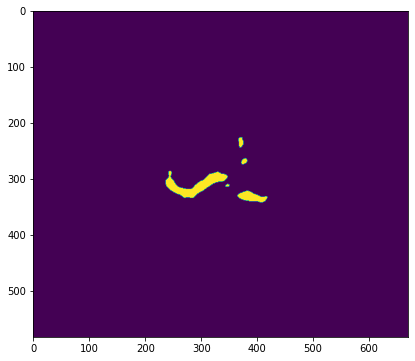

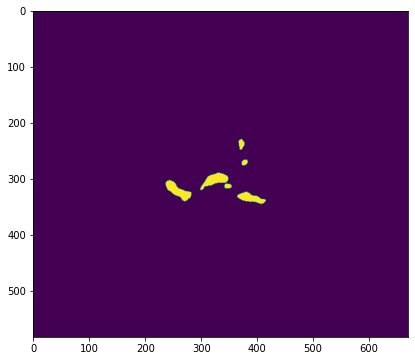

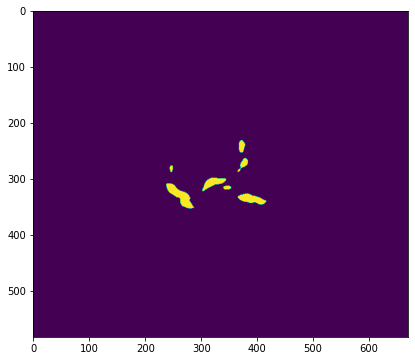

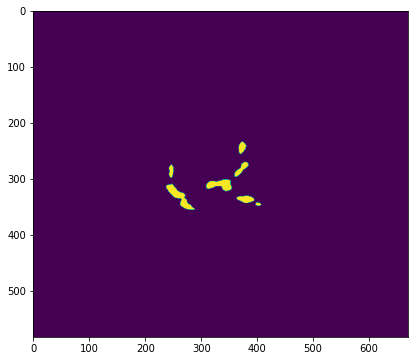

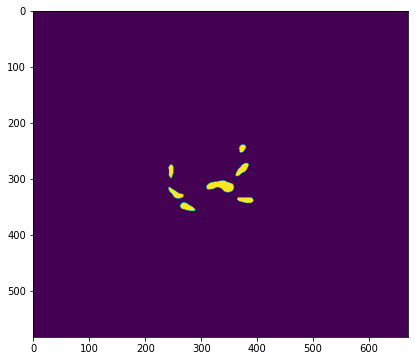

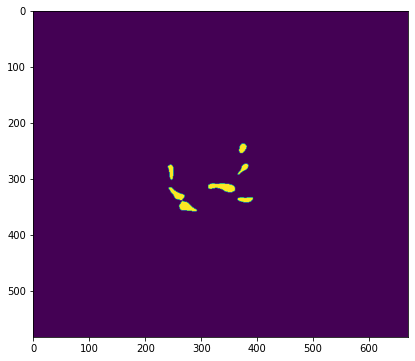

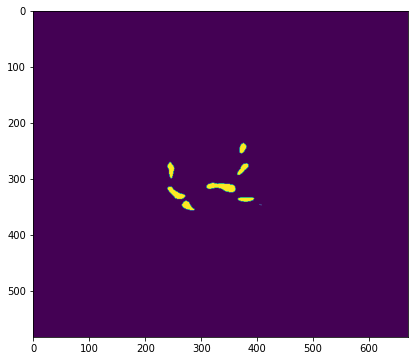

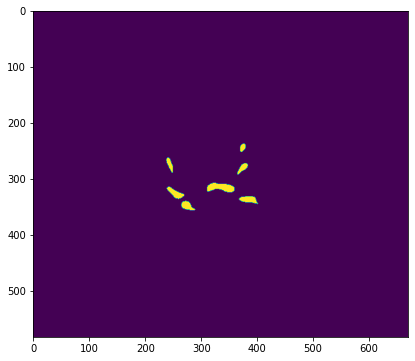

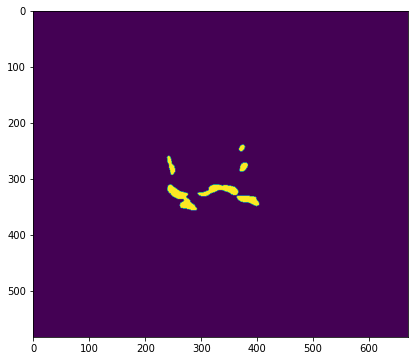

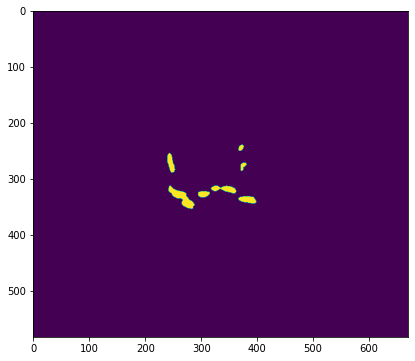

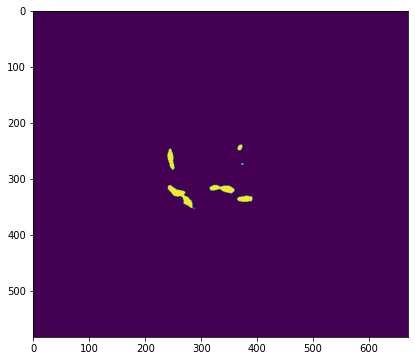

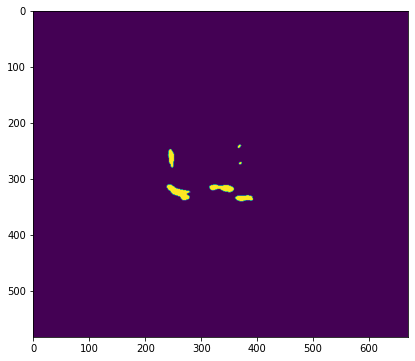

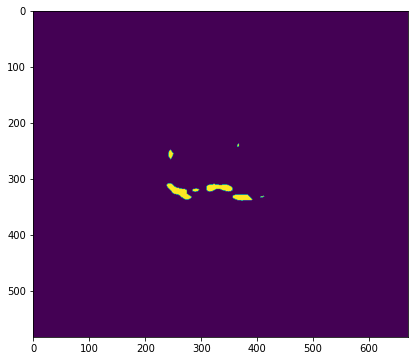

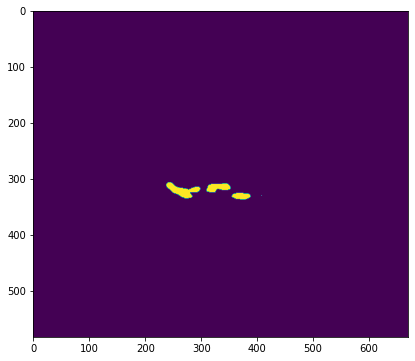

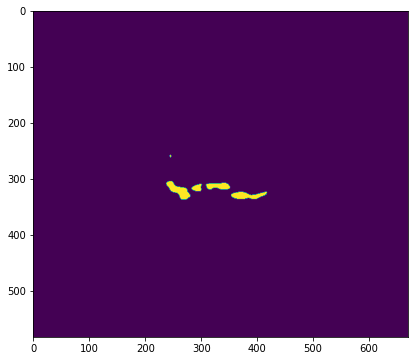

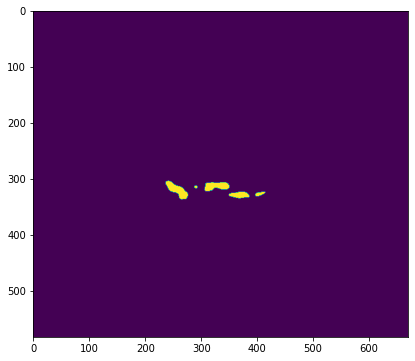

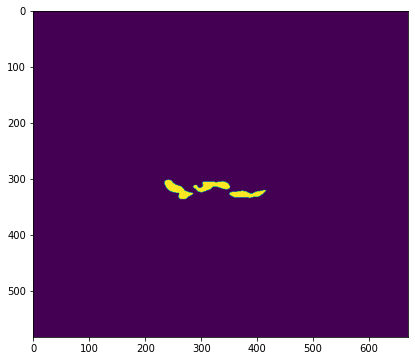

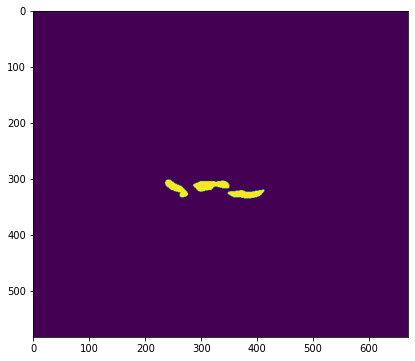

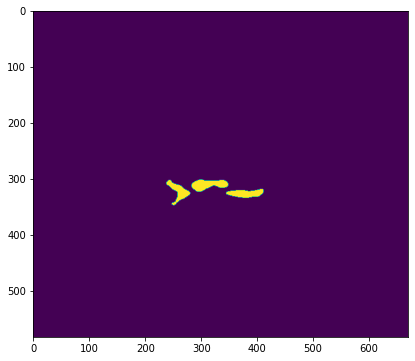

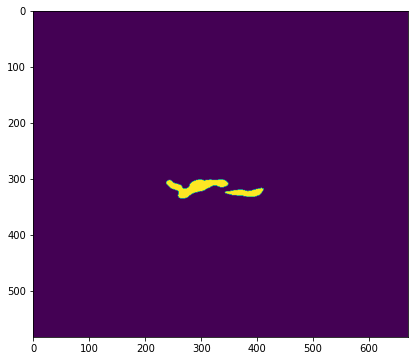

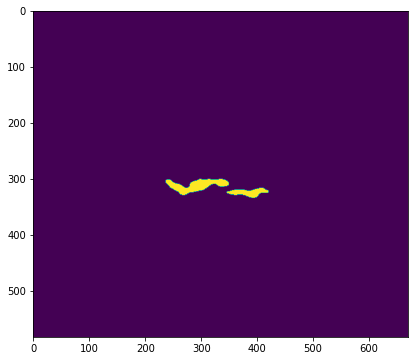

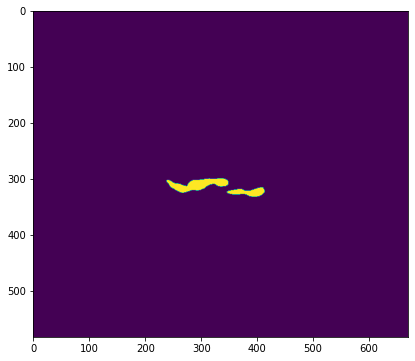

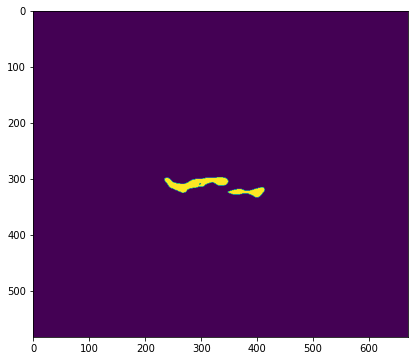

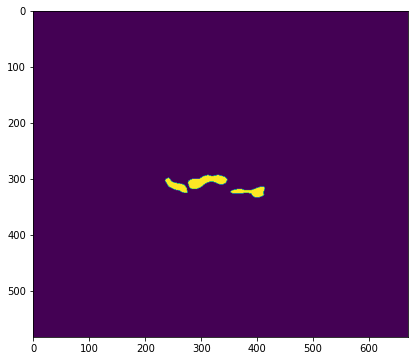

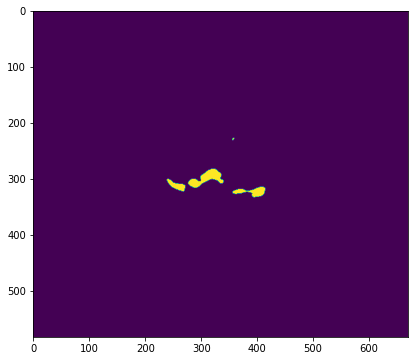

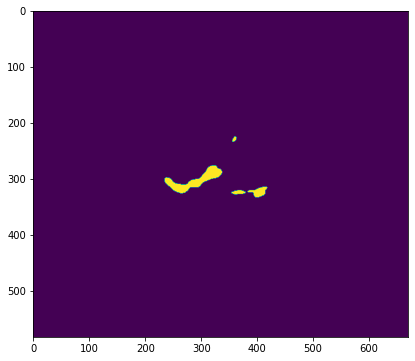

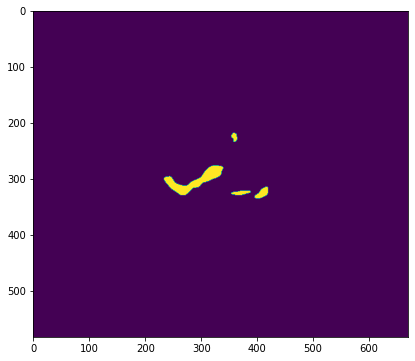

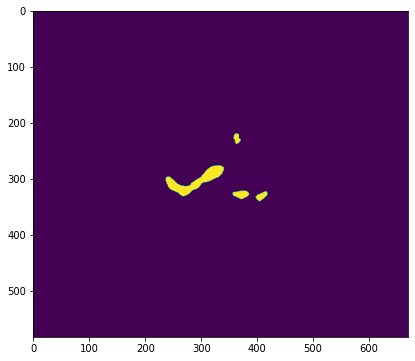

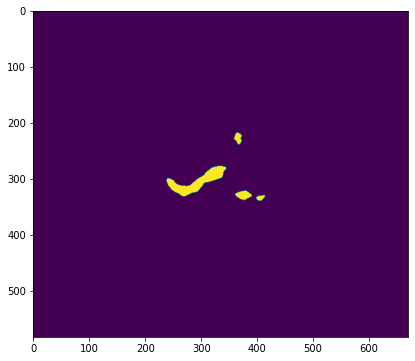

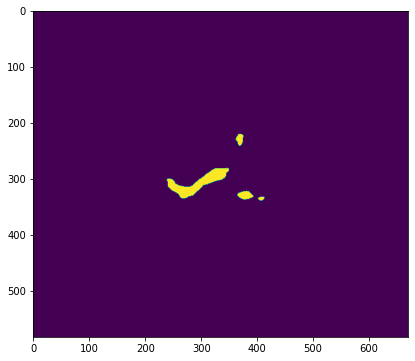

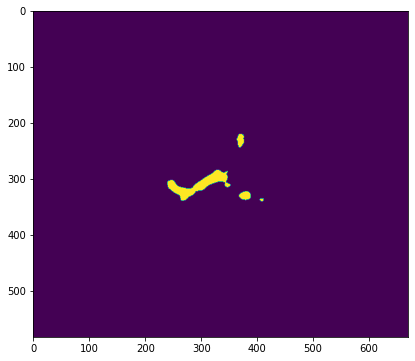

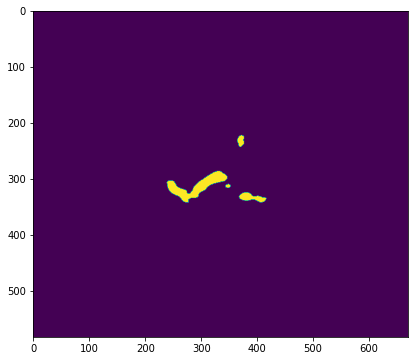

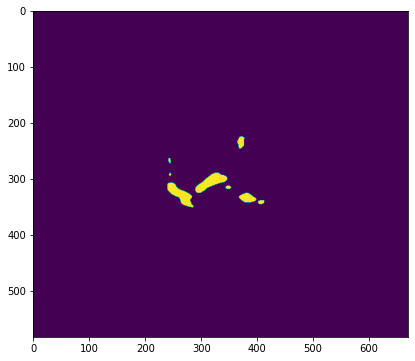

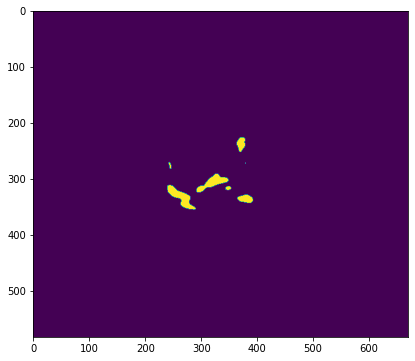

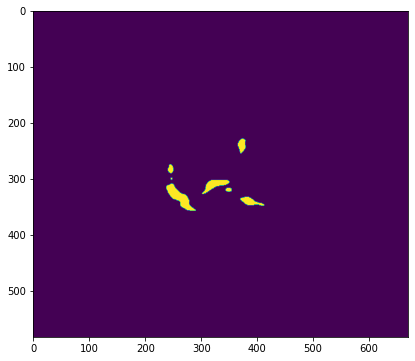

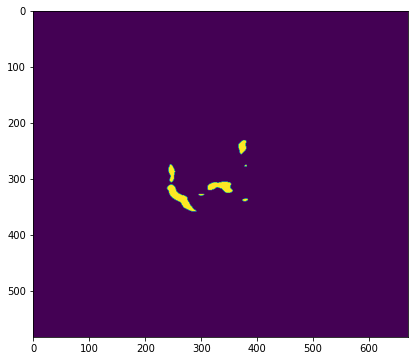

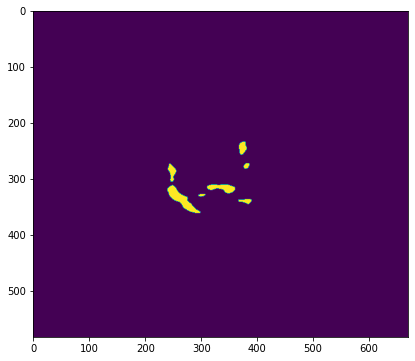

In [25]:
for idx, item in enumerate(submissions_corrected):

    name = item['name']
    pred = item['prediction']

    if name == '0MVRNDWR1G':

        for frame in range(pred.shape[-1]):

            fig, ax = plt.subplots(figsize=(8,6))
            # original frame
            ax.imshow(pred[:,:,frame])

### Helper function - not used

In [ ]:
# make prediction for test, from helper file
predictions = []

for d in test_data:
    prediction = np.array(np.zeros_like(d['video']), dtype=np.bool)
    height = prediction.shape[0]
    width = prediction.shape[1]
    prediction[int(height/2)-50:int(height/2+50), int(width/2)-50:int(width/2+50)] = True
    
    # DATA Strucure
    predictions.append({
        'name': d['name'],
        'prediction': prediction
        }
    )

### Run predictions on validation

In [ ]:

predictions = []
labels = []
for i, batch in enumerate(validation_loader):
    frame = batch['frame_cropped']
    label = batch['label_cropped'] # if not submission
    name = batch['name']
    prediction = model(frame)
    prediction_thr = prediction > 0.5

    predictions.append({
        'name': name,
        'prediction': prediction_thr
        }
    )
    labels.append({
        'name':name,
        'label': label
    })

    iou = metric(prediction_thr, label)
    print(frame.shape)
    print(name)
    print(f'IoU score: {iou}') #>>> jaccard(pred, target)

    show_img_batch(batch, pred=prediction_thr.detach())
    #show_img_batch(batch) # when submission (to check)
    print('\n----------------------------------------\n')

### Median IoU (project evaluation)

In [28]:
evaluate(predictions=predictions, targets=labels)

Median IoU (project evaluation):

Median IOU:  0.40225600656913285
